In [6]:
%load_ext autoreload
%autoreload 2

from IPython.display import clear_output

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
%reload_ext autoreload

In [8]:
import numpy as np
import scipy

In [9]:
from libs.plotting import plot_lcs
from astropy.table import Table

### Load data

In [10]:
from dataset import radio_mrk501, gev_mrk501, coincidence_mask_mrk501

from dataset import radio_mrk501_orig

from dataset import coincidence_checker
import matplotlib.pyplot as plt

### Define response profile and convolution routine

In [11]:
def profile_st(x, Amp, t_rise, t_fall, t_shift):
    t = x - t_shift
    return Amp * np.exp(-t/t_fall) / (1 + np.exp(-t/t_rise))

def convolve_arrays_sigma(v1, v2, dv1):
    v1, v2, dv1 = np.array(v1), np.array(v2), np.array(dv1)
    r = np.convolve(v1, v2)
    dr2 = np.convolve(dv1 ** 2, v2 ** 2)
    return r, np.sqrt(dr2)

### Define fit configuration and fitting routines

In [12]:
def prepare_fit(s_data_ds, r_data_ds, bin_size, fit_roi, time_start=None, noplot=False):
    s_data = s_data_ds
    r_data = r_data_ds
    
    s_m, r_m = coincidence_checker(s_data, r_data, bin_size=bin_size)
    
    sd = Table({i:s_data_ds[i][s_m] for i in s_data_ds.columns})
    sd.meta = s_data_ds.meta
    for c in s_data_ds.columns:
        sd[c].unit = s_data_ds[c].unit
    
    rd = Table({i:r_data_ds[i][r_m] for i in r_data_ds.columns})
    rd.meta = r_data_ds.meta
    for c in r_data_ds.columns:
        rd[c].unit = r_data_ds[c].unit
    
    if not noplot:
        plot_lcs(sd, rd, extra_data=[s_data_ds, r_data_ds], highlights=[None, fit_roi], figsize=(10, 6))
    return s_data, r_data, s_m, r_m, bin_size, fit_roi, s_data_ds, r_data_ds, sd, rd


def get_fit(params, 
            configuration, 
            profile_func, 
            t_shift=None, 
            const_flux_present=False, 
            all_uncertainties=False, 
            exclude_roi=[], 
            plot_data=False, 
            curvefit=False, 
            syn_delay=0, 
            result=False,  
            ylims=None, 
            start_time=None, 
            highlight=None,
            plot_timerange=None,
            dst_data=None, 
            color='black',
            extra_data=None,
            extra_color='#1f77b4', #'#11265b',
            filename='tmp.png',
            flare_tuning = None,
            background=None,
            extra_plot=None,
            get_dof = False,
            plot_flares=False
           ):
    s_data, r_data, s_m, r_m, bin_size, fit_roi, s_data_ds, r_data_ds, sd, rd = configuration
    s_t, s_f, s_df = s_data['tc'], s_data['f'], s_data['df']
    r_t, r_f, r_df = r_data['tc'], r_data['f'], r_data['df']
    
    const_flux = 0
    if const_flux_present:
        const_flux = params[-1]
        params = params[:-1]        
    if t_shift is not None:
        params = [*params] + [t_shift]
    prof = profile_func(s_t - min(s_t), *params)
    _params = [i for i in params]
    A0 = params[0]
    syn_t = s_t
    syn_f = np.zeros_like(s_f)
    syn_df = np.zeros_like(s_df)
    if flare_tuning is None:
        syn = convolve_arrays_sigma(s_f.copy(), prof, s_df)
        syn_f = syn[0][:len(s_f)] + const_flux
        syn_df = syn[1][:len(s_f)]
    else:
        fig = None
        if plot_flares:
            fig = plt.figure(figsize=(15,5))
        for f in flare_tuning:
            _time_range, amplitude = f
            _tmp_s_f = np.zeros_like(s_f)
            _tmp_s_df = np.zeros_like(s_df)
            m = np.logical_and(syn_t > _time_range[0], syn_t <= _time_range[1])
            _tmp_s_f[m] = s_f.copy()[m]
            _tmp_s_df[m] = s_df.copy()[m]
            _params[0] = A0 * amplitude
            prof = profile_func(s_t - min(s_t), *_params)
            syn = convolve_arrays_sigma(_tmp_s_f, prof, _tmp_s_df)
            syn_f += syn[0][:len(s_f)]
            syn_df += syn[1][:len(s_f)]**2
            if plot_flares:
                plt.plot(s_t, syn[0][:len(s_f)] + const_flux, '.', label="%s" % _time_range)
        syn_t = s_t   
        if background is not None:
            syn_f += background(s_t, const_flux)
        else:
            syn_f += const_flux
        syn_df = 0*np.sqrt(syn_df)
        if plot_flares:
            plt.legend()
            plt.show()
        
    roi_mask = np.logical_and(r_t[r_m] >= fit_roi[0], r_t[r_m] <= fit_roi[1])
    
    _r_t = r_t[r_m][roi_mask]
    _r_f = r_f[r_m][roi_mask]
    _r_df = r_df[r_m][roi_mask]
    
    _s_t = syn_t[s_m][roi_mask]
    _s_f = syn_f[s_m][roi_mask]
    _s_df = syn_df[s_m][roi_mask]
    
    if curvefit:
        return np.column_stack([_r_t, _r_f, _r_df]), np.column_stack([_s_t, _s_f, _s_df])
    
    delta = _r_df
    if all_uncertainties:
        delta = np.sqrt(_r_df**2 + _s_df**2)
    
    xi = ((_s_f - _r_f)/delta)**2
    xi_t = _s_t
    for p in exclude_roi:
        m = np.logical_and(xi_t >= p[0], xi_t <= p[1])
        xi = xi[~m]
        xi_t = xi_t[~m]
    
    dof = len(xi) - len(params) - (1 if const_flux_present else 0)
    chi2 = np.sum(xi)
    
    if get_dof:
        return chi2/dof, dof
        
    if not plot_data:
        #clear_output(wait=True)
        #display("chi2 = %s (%s), params = %s, delta_t = %s" % (chi2, len(xi), np.array(params), t_shift))
        return chi2/dof
    else:
        p = [i for i in params]
        if const_flux_present:
            p += [const_flux]
            
        print("chi2/dof = %s/%s = %s, params = %s, t_shift=%s" % (chi2, dof, chi2/dof, str(p), t_shift))
    

        syn_full = Table({'tc' : syn_t + syn_delay, 'f' : syn_f, 'df' : syn_df})
        syn_full.meta['title'] = "Synthetic LC"
        syn_full.meta['f_units'] = "Jy"

        sn = Table({'tc' : _s_t + syn_delay, 'f' : _s_f, 'df' : _s_df})
        sn.meta['title'] = "Synthetic LC"
        sn.meta['f_units'] = "Jy"

                
        #plot_lcs(sd, sn, rd, extra_data=[s_data_ds, syn_full, r_data_ds], highlights=[None, fit_roi, fit_roi], figsize=(10, 10), filename='images/gev_syn_radio.eps')
        
        _highlight = fit_roi if highlight is None else highlight
        _dst_data = rd if dst_data is None else dst_data
        
        
        
        def inset_creator(ax):
            x = np.linspace(0, 700, 1000)
            A, t_rise, t_decay, f_const = 197765.3421157885, 19.24416937907919, 42.883458356259524, 26.973314037084446
            delta_t = 255
            p = profile_func(x - min(x), *params)
            ax.plot(x, p/np.max(p))
            ax.set_ylabel("$S/S_{max}$")
            ax.set_xlabel('$t$ (d)')

        
        plot_lcs(s_data, sn, _dst_data, extra_data=extra_data, extra_plot=extra_plot, highlights=[None, _highlight, _highlight, None], extra_color=extra_color, color=color, figsize=(11, 9), ylims=ylims, timerange=plot_timerange, filename=filename, inset_creator=inset_creator, inset_id=1)
       
        return sd, sn, rd, chi2, dof, _r_t, _r_f, _r_df, _s_t, _s_f, _s_df, syn_full

### Define fitting configurations

In [13]:
mrk501_plot_timerange = [56300, 58226]

con_f7d1g = prepare_fit(gev_mrk501, radio_mrk501, bin_size=7, fit_roi=[56800, 58500], noplot=True)

con_plot_mrk501 = prepare_fit(gev_mrk501, radio_mrk501, bin_size=7, fit_roi=[56275, 58226], noplot=True)

### Perform fitting

### Plot resulting LCs

224
chi2/dof = 435.9698803350107/149 = 2.9259723512416826, params = [1665799.898661404, 3.355918705118255, 66.5926745199267, 224, 0.9151354379043237], t_shift=224
Mrk 501 using UL


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


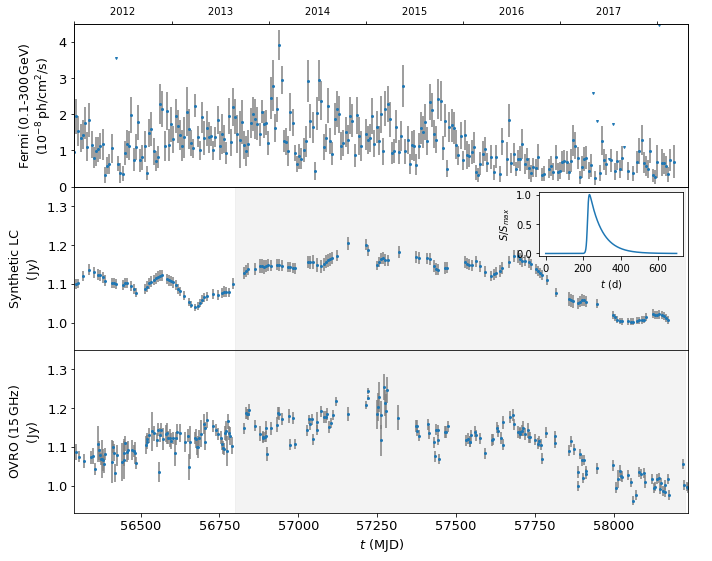

In [14]:
t = 224
x = [1665799.898661404, 3.355918705118255, 66.5926745199267, 0.9151354379043237]
print(t)
ylims = [[0, 0.45E-7], [0.93, 1.35], [0.93, 1.35], [None, None]]
result = get_fit(x, con_plot_mrk501, profile_st, t, True, extra_data=[gev_mrk501, None, None], plot_data=True, ylims=ylims, all_uncertainties=True, highlight=[56800, 58226], dst_data=radio_mrk501_orig, plot_timerange=mrk501_plot_timerange, color='#1f77b4', filename='images/gev_syn_radio_mrk501.eps')

### Estimate parameters uncertainties

In [15]:
#
# threshold 5.9 from https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html, dof=5, P(X<x)=0.68
#
params = [224, 1665799.898661404, 3.355918705118255, 66.5926745199267, 0.9151354379043237]
x0, dof = get_fit(params[1:], con_f7d1g, profile_st, params[0], True, all_uncertainties=True, get_dof=True)

for _p in range(len(params)):
    params1 = [i for i in params]
    res = []
    ps = []
    for p in np.linspace(0.5 * params[_p], 1.5 * params[_p], 1000):
        params1[_p] = p
        x1 = get_fit(params1[1:], con_f7d1g, profile_st, params1[0], True, all_uncertainties=True)
        res.append(np.abs(np.abs(x1 - x0) * dof - 5.9))
        ps.append(p)
    res = np.array(res)
    ps = np.array(ps)
    par = params[_p]
    m1 = ps[ps <= par][np.argmin(res[ps <= par])]
    m2 = ps[ps >= par][np.argmin(res[ps >= par])]
    print(f"{par} -{par - m1} +{m2 - par} || {m1} & {m2}")
    #plt.plot(ps, res, '-')
    #plt.ylim([0, 5.9])
    #plt.show()

224 -12.668668668668658 +3.0270270270270316 || 211.33133133133134 & 227.02702702702703
1665799.898661404 -29180.678905480076 +49190.287297809264 || 1636619.2197559238 & 1714990.1859592132
3.355918705118255 -1.6779593525591274 +1.6779593525591276 || 1.6779593525591274 & 5.0338780576773825
66.5926745199267 -1.4331756778562834 +1.5664943455638394 || 65.15949884207042 & 68.15916886549054
0.9151354379043237 -0.0041222317022717725 +0.0041222317022717725 || 0.911013206202052 & 0.9192576696065955
